# Feature selection

This demonstration notebook shows some of the available methods for feature selection including implemented "merit"-based algorithm using correlation of features.
1. It starts with example of feature selection how it is usually done (using Lasso regression),
2. continues with brief description of new method and
3. ends with examples of various parameters of the algorithm, how they work and what are their use cases.

## Import functions and modules

In [0]:
from datasciencefunctions.feature_selection import feature_selection_merits

import pandas as pd

## Creation of dataset

In [0]:
import sklearn.datasets

data = sklearn.datasets.load_boston()
pd_df = pd.DataFrame(data["data"], columns=data.feature_names)
pd_df["target"] = data["target"]

pd_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


# Feature selection using ML models
Typically we use ML models for feature selection. Most often utilised are decision trees and Lasso regressions. The disadvantage is that we need to train multiple models (because we are often using some hyperparameters). This could be quite time consuming on large datasets. Below is an example of Lasso feature selection and then our merit-based algorithm.

---

## Lasso regression

In [0]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

X = pd_df[[col for col in pd_df.columns if col != "target"]]
y = pd_df["target"]

# for simplicity we just transform the data without defining a pipeline
scaler = StandardScaler()
X_sc = scaler.fit(X).transform(X)

# ...after some hyperparameter tuning (i.e. changing alpha)
clf = Lasso(alpha=0.9)

clf.fit(X_sc, y)

pd.DataFrame(clf.coef_, X.columns, columns=["coefficient"]).abs().sort_values(
    "coefficient", ascending=False
)

,coefficient
LSTAT,3.558711
RM,2.768497
PTRATIO,1.394847
B,0.255031
CHAS,0.083791
CRIM,0.000000
ZN,0.000000
INDUS,0.000000
NOX,0.000000
AGE,0.000000


We select LSTAT, RM, PTRATIO, B, and perhaps CHAS.

---

# Feature selection using correlation and "merits"
No model is fitted, we use general idea that you want to select features which are related to target, but as much as possible independent of each other. The most direct metric here is correlation, but any similarity metric can be used. Details can be found on [wikipedia](https://en.wikipedia.org/wiki/Feature_selection#Correlation_feature_selection).

As such, it works only for continuous variables, but you can use various tricks to make it work for cathegorical too (e.g. WoE transformation, different metric than correlation, &hellip;).

**Footnote 1:** We are using squared merit as it is same optimisation problem and no rounding errors are introduced.

**Footnote 2:** If you have e.g. 500 observations, then `|corr(x,y)|` is nothing else then `cos()` of the angle between the x and y in the 500 dimensional vector space. This algorithm is looking for variables which are mutually correlated as little as possible (i.e. as ortogonal as possible) and at the same time as much aligned with target as possible.

---

## Creating inputs using `pandas.DataFrame.corr()`
Since we already have the data as a Pandas DataFrame, we can easily obtain the input format by calling method `corr()`. If we had bigger data, we could use Spark to calculate the correlations, convert the resulting matrix to Pandas (changing the column names and index accordingly) and continue from there.

In [0]:
df_corr = pd_df.corr()

# extraction of feature and target corelations
corr_target_small = df_corr.loc[["target"], df_corr.columns != "target"]  # row vector
corr_features_small = df_corr.loc[
    df_corr.columns != "target", df_corr.index != "target"
]  # matrix

In [0]:
# pair-wise correlations between features
corr_features_small = corr_features_small.abs()
corr_features_small

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,0.200469,0.406583,0.055892,0.420972,0.219247,0.352734,0.379670,0.625505,0.582764,0.289946,0.385064,0.455621
ZN,0.200469,1.000000,0.533828,0.042697,0.516604,0.311991,0.569537,0.664408,0.311948,0.314563,0.391679,0.175520,0.412995
INDUS,0.406583,0.533828,1.000000,0.062938,0.763651,0.391676,0.644779,0.708027,0.595129,0.720760,0.383248,0.356977,0.603800
CHAS,0.055892,0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,0.099176,0.007368,0.035587,0.121515,0.048788,0.053929
NOX,0.420972,0.516604,0.763651,0.091203,1.000000,0.302188,0.731470,0.769230,0.611441,0.668023,0.188933,0.380051,0.590879
RM,0.219247,0.311991,0.391676,0.091251,0.302188,1.000000,0.240265,0.205246,0.209847,0.292048,0.355501,0.128069,0.613808
AGE,0.352734,0.569537,0.644779,0.086518,0.731470,0.240265,1.000000,0.747881,0.456022,0.506456,0.261515,0.273534,0.602339
DIS,0.379670,0.664408,0.708027,0.099176,0.769230,0.205246,0.747881,1.000000,0.494588,0.534432,0.232471,0.291512,0.496996
RAD,0.625505,0.311948,0.595129,0.007368,0.611441,0.209847,0.456022,0.494588,1.000000,0.910228,0.464741,0.444413,0.488676
TAX,0.582764,0.314563,0.720760,0.035587,0.668023,0.292048,0.506456,0.534432,0.910228,1.000000,0.460853,0.441808,0.543993


In [0]:
# correlation of each feature with target
corr_target_small = corr_target_small.abs()
corr_target_small

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
target,0.388305,0.360445,0.483725,0.17526,0.427321,0.69536,0.376955,0.249929,0.381626,0.468536,0.507787,0.333461,0.737663


## Let's run the merit based feature selection algorithm.

In [0]:
result, history = feature_selection_merits(corr_features_small, corr_target_small)

result  # best subset of features as found by the algorithm

Out[7]: frozenset({'LSTAT', 'PTRATIO', 'RM'})

In [0]:
history  # complete history of searching the feature subsets

,iteration,rank,features,merit_sq,num_features
0,0,0,[],0.000000,0
1,1,0,[LSTAT],0.544146,1
2,2,0,"[RM, LSTAT]",0.636245,2
3,3,0,"[LSTAT, RM, PTRATIO]",0.662376,3


## Usage examples and configuration of merit-based feature selection algorithm
Below are examples of the effect of individual parameters. For details, see functions documentation either on website or in Python as `help(feature_selection_merits)`.

#### Starting features
Determines from which feature set should the algorithmic search start.

In [0]:
# starting from ['B', 'NOX', 'DIS']
startf_result, startf_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="stepwise",
    starting_features=["B", "NOX", "DIS"],
)
startf_history

,iteration,rank,features,merit_sq,num_features
0,0,0,"[DIS, B, NOX]",0.173684,3
1,1,0,"[DIS, B, NOX, RM]",0.357025,4
2,2,0,"[B, NOX, RM]",0.458889,3
3,3,0,"[B, NOX, RM, LSTAT]",0.549268,4
4,4,0,"[NOX, LSTAT, B, PTRATIO, RM]",0.610562,5


You can see that starts with [DIS, B, NOX], then adds 'RM', removes 'DIS', etc.

---

#### Type of algorithm
We have two types: _stepwise_ selects the best and in each steps tries to remove features too, _forward_ just keeps adding.

For the demonstration of the stepwise, lets just repeat the example above and start with set ['B', 'NOX', 'DIS']. We will see that the features are added and removed.

In [0]:
stepwise_result, stepwise_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="stepwise",
    starting_features=["B", "NOX", "DIS"],
)
stepwise_history

,iteration,rank,features,merit_sq,num_features
0,0,0,"[DIS, B, NOX]",0.173684,3
1,1,0,"[DIS, B, NOX, RM]",0.357025,4
2,2,0,"[B, NOX, RM]",0.458889,3
3,3,0,"[B, NOX, RM, LSTAT]",0.549268,4
4,4,0,"[NOX, LSTAT, B, PTRATIO, RM]",0.610562,5


Sometimes we have the "optimal feature set" and we just want to add several features "just to be sure". This is the use case for the _forward_ algorithm.

Lets fetch it the _stepwise_result_ as starting point and run it.

In [0]:
forward_result, forward_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="forward",
    starting_features=stepwise_result,
)
forward_history

,iteration,rank,features,merit_sq,num_features
0,0,0,"[B, NOX, PTRATIO, RM, LSTAT]",0.610562,5
1,1,0,"[NOX, CHAS, LSTAT, B, PTRATIO, RM]",0.601156,6
2,2,0,"[NOX, CHAS, LSTAT, CRIM, B, PTRATIO, RM]",0.578763,7
3,3,0,"[NOX, CHAS, LSTAT, CRIM, B, PTRATIO, ZN, RM]",0.558775,8
4,4,0,"[NOX, CHAS, TAX, CRIM, LSTAT, B, PTRATIO, ZN, RM]",0.537175,9


We can see that the squared merit is decreasing gradually. We could use either this history, or use the _max_iter_ parameter to stop after several iterations (let's say, we we want to stop after adding two additional features).

In [0]:
forward2_result, forward2_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="forward",
    starting_features=stepwise_result,
    max_iter=2,
)

print(forward2_result)
forward2_history

,iteration,rank,features,merit_sq,num_features
0,0,0,"[B, NOX, PTRATIO, RM, LSTAT]",0.610562,5
1,1,0,"[NOX, CHAS, LSTAT, B, PTRATIO, RM]",0.601156,6
2,2,0,"[NOX, CHAS, LSTAT, CRIM, B, PTRATIO, RM]",0.578763,7


### Frozen features
Forces preselected features to be in the resulting set.

Let's say, that for some reason you need 'AGE' and 'NOX' features in the selected set. _frozen_features_ is parameter for this occasion.

In [0]:
frozen_result, frozen_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="stepwise",
    frozen_features=["AGE", "NOX"],
)
frozen_history

,iteration,rank,features,merit_sq,num_features
0,0,0,"[NOX, AGE]",0.186795,2
1,1,0,"[NOX, RM, AGE]",0.405366,3
2,2,0,"[NOX, RM, AGE, PTRATIO]",0.493856,4
3,3,0,"[NOX, AGE, LSTAT, PTRATIO, RM]",0.557281,5


### Maximum iteration
For datasets with lots of features, it makes sense to limit number of iterations. Also, the default value of 1/3 of features might be too small.

In [0]:
maxiter_result, maxiter_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="forward",
    max_iter=10,
)
maxiter_history

,iteration,rank,features,merit_sq,num_features
0,0,0,[],0.000000,0
1,1,0,[LSTAT],0.544146,1
2,2,0,"[RM, LSTAT]",0.636245,2
3,3,0,"[LSTAT, RM, PTRATIO]",0.662376,3
4,4,0,"[B, RM, PTRATIO, LSTAT]",0.644140,4
5,5,0,"[CHAS, LSTAT, B, PTRATIO, RM]",0.621090,5
6,6,0,"[CHAS, INDUS, LSTAT, B, PTRATIO, RM]",0.603449,6
7,7,0,"[CHAS, INDUS, LSTAT, CRIM, B, PTRATIO, RM]",0.584278,7
8,8,0,"[CHAS, INDUS, LSTAT, CRIM, B, PTRATIO, ZN, RM]",0.564386,8
9,9,0,"[CHAS, INDUS, TAX, CRIM, LSTAT, B, PTRATIO, ZN...",0.541630,9


### Take best N sets in each iteration
The parameter _best_n_ takes best n feature sets in each set and continues from those in next iteration. You can explore larger feature set space and decrease the probability of ending in some local optimum at the cost of more computational time.

In [0]:
bestn_result, bestn_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="forward",
    best_n=2,
    max_iter=5,
)
bestn_history

,iteration,rank,features,merit_sq,num_features
0,0,0,[],0.000000,0
1,0,1,[],0.000000,0
2,1,0,[LSTAT],0.544146,1
3,1,1,[RM],0.483525,1
4,2,0,"[RM, LSTAT]",0.636245,2
5,2,1,"[PTRATIO, LSTAT]",0.564445,2
6,3,0,"[LSTAT, RM, PTRATIO]",0.662376,3
7,3,1,"[TAX, RM, LSTAT]",0.612900,3
8,4,0,"[B, RM, PTRATIO, LSTAT]",0.644140,4
9,4,1,"[LSTAT, NOX, RM, PTRATIO]",0.633626,4


## Visualisation of the process

In [0]:
import seaborn as sns

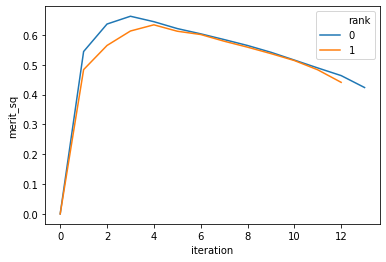

In [0]:
_, vis_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="forward",
    best_n=2,
    max_iter=20,
)


sns.lineplot(data=vis_history, x="iteration", y="merit_sq", hue="rank")
plt.show()

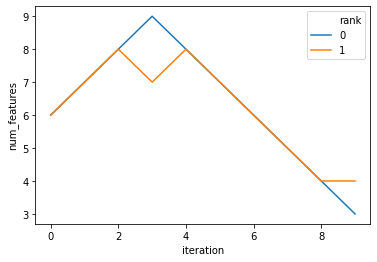

In [0]:
_, vis2_history = feature_selection_merits(
    features_correlations=corr_features_small,
    target_correlations=corr_target_small,
    algorithm="stepwise",
    starting_features=["CHAS", "INDUS", "TAX", "CRIM", "B", "ZN"],
    best_n=2,
    max_iter=20,
)

sns.lineplot(data=vis2_history, x="iteration", y="num_features", hue="rank")
plt.show()